In [42]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

def load_images_from_directory(directory, target_size=(224, 224)):
    image_paths = [os.path.join(directory, file) for file in os.listdir(directory) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
    images = [load_img(path, target_size=target_size) for path in image_paths]
    images_array = np.array([img_to_array(image) for image in images])
    return preprocess_input(images_array), image_paths

images, image_paths = load_images_from_directory("../final_figures/2022")


from tensorflow.keras.applications import VGG16

def extract_features(images_array):
    model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    return model.predict(images_array)

features = extract_features(images)

from tensorflow.keras.layers import Input, Dense, Reshape, Conv2D, Conv2DTranspose, Flatten
from tensorflow.keras.models import Model

# def build_autoencoder(input_shape):
#     input_layer = Input(shape=input_shape)
    
#     # Encoder
#     x = Conv2D(128, (3, 3), activation='relu', padding='same')(input_layer)
#     x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    
#     # Decoder
#     x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
#     x = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
#     output_layer = Conv2D(512, (3, 3), activation='sigmoid', padding='same')(x)  # Use 'sigmoid' if the data range is [0,1]
    
#     return Model(inputs=input_layer, outputs=output_layer)

# autoencoder = build_autoencoder((7, 7, 512))
# autoencoder.compile(optimizer='adam', loss='mse')
# Assuming 'features' is a 4D tensor from VGG16 with shape (num_samples, 7, 7, 512)
# autoencoder.fit(features, features, epochs=50, batch_size=32)

def build_encoder(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # Flatten the output to make it suitable for the dense layer or reshape for decoder
    x = Flatten()(x)
    encoded = Dense(3136, activation='relu')(x)  # Adjust the dense layer to match decoder's expected input
    return Model(inputs, encoded, name='encoder')

def build_decoder(encoded_shape):
    # Assuming the encoded output is flattened and matches the decoder's expected input
    inputs = Input(shape=(encoded_shape,))
    x = Reshape((7, 7, 64))(inputs)  # Adjust the reshape parameters to match expected decoder's input
    x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2DTranspose(512, (3, 3), activation='sigmoid', padding='same')(x)
    return Model(inputs, x, name='decoder')

# Dimensions must be consistent
encoder = build_encoder((224, 224, 3))
decoder = build_decoder(3136)  # Ensure this matches the flattened dimension encoder outputs
autoencoder = Model(encoder.input, decoder(encoder.output))
autoencoder.compile(optimizer='adam', loss='mse')

import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.cluster import KMeans

# Function to load images
def load_images_from_directory(directory, target_size=(224, 224)):
    image_paths = [os.path.join(directory, file) for file in os.listdir(directory) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
    images = [load_img(path, target_size=target_size) for path in image_paths]
    images_array = np.array([img_to_array(image) for image in images])
    return preprocess_input(images_array), image_paths

# Load images
images_array, image_paths = load_images_from_directory("../clustered_images/2022/conceptual diagram/cluster_0")

# Extract features with VGG16
def extract_features(images_array):
    model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling=None)
    return model.predict(images_array)

# Extract features
features = extract_features(images_array)

# Reshape the features from 4D to 2D for clustering
flattened_features = features.reshape(features.shape[0], -1)

# Find cluster center with KMeans
def find_cluster_center(features):
    kmeans = KMeans(n_clusters=1, random_state=42)
    kmeans.fit(features)
    return kmeans.cluster_centers_


# Find cluster center
cluster_center = find_cluster_center(flattened_features)

# Reshape cluster center to fit the decoder's input
# Ensure the shape aligns with the output of the encoder part
cluster_center_reshaped = cluster_center.reshape(-1, 7, 7, 64)  # Adjust according to your encoder's final output

# Predict using the decoder
predicted_image = decoder.predict(cluster_center_reshaped)

# Visualize the output
plt.figure(figsize=(5, 5))
plt.imshow(predicted_image[0], cmap='gray')  # Assuming the output is normalized between 0 and 1
plt.title('Reconstructed Image from Cluster Center')
plt.axis('off')
plt.show()



3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 62.1993
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 61.7377
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 62.7635
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 60.3572
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 61.5589
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 61.9138
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 61.1060
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 61.3611
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 60.5710
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 61.7442 
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 61.4955
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 60.8915
Epoch 13/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 58.9892
Epoch 14/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 62.2759
Epoch 15/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 61.2873
Epoch 16/50
3/3 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


TypeError: Invalid shape (7, 7, 512) for image data

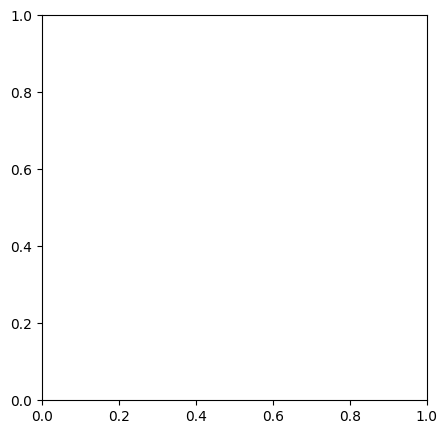

In [37]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.cluster import KMeans

# Function to load images
def load_images_from_directory(directory, target_size=(224, 224)):
    image_paths = [os.path.join(directory, file) for file in os.listdir(directory) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
    images = [load_img(path, target_size=target_size) for path in image_paths]
    images_array = np.array([img_to_array(image) for image in images])
    return preprocess_input(images_array), image_paths

# Load images
images_array, image_paths = load_images_from_directory("../clustered_images/2022/conceptual diagram/cluster_0")

# Extract features with VGG16
def extract_features(images_array):
    model = VGG16(include_top=False, input_shape=(224, 224, 3), pooling=None)
    return model.predict(images_array)

# Extract features
features = extract_features(images_array)

# Reshape the features from 4D to 2D for clustering
flattened_features = features.reshape(features.shape[0], -1)

# Find cluster center with KMeans
def find_cluster_center(features):
    kmeans = KMeans(n_clusters=1, random_state=42)
    kmeans.fit(features)
    return kmeans.cluster_centers_

# Get the cluster center
cluster_center = find_cluster_center(flattened_features)
cluster_center_reshaped = cluster_center.reshape(-1, 7, 7, 512)

# Assuming the autoencoder expects a (1, 7, 7, 512) input shape:
predicted_image = decoder.predict(cluster_center_reshaped) 

# Visualize the output
plt.figure(figsize=(5, 5))
plt.imshow(predicted_image[0], cmap='gray')  # Adjust reshape based on actual output dimension
plt.title('Reconstructed Image from Cluster Center')
plt.axis('off')
plt.show()


ValueError: cannot reshape array of size 512 into shape (7,7,512)

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.cluster import KMeans
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, MaxPooling2D

def load_and_preprocess_images(directory, target_size=(224, 224)):
    image_paths = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith(('.png', '.jpg', '.jpeg'))]
    images = [load_img(path, target_size=target_size) for path in image_paths]
    images_array = np.array([img_to_array(image) for image in images])
    images_array = preprocess_input(images_array)
    return images, images_array

def extract_features(images_array):
    model = VGG16(weights='imagenet', include_top=False)
    features = model.predict(images_array)
    features_flattened = features.reshape(features.shape[0], -1)
    return features_flattened

def cluster_features(features_flattened, n_clusters=1):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(features_flattened)
    return kmeans.cluster_centers_

# Define the autoencoder architecture
def build_autoencoder():
    input_img = Input(shape=(224, 224, 3))
    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    # Decoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder

# Load images from a specific directory
directory = "../clustered_images/2022/conceptual diagram/cluster_0"
images, images_array = load_and_preprocess_images(directory)

# Extract features using VGG16
features_flattened = extract_features(images_array)

# Cluster features into 1 cluster
cluster_centers = cluster_features(features_flattened, n_clusters=1)

# Initialize and compile the autoencoder
autoencoder = build_autoencoder()

# Assuming the autoencoder is trained, use the decoder part to generate an image from the cluster center
decoded_img = autoencoder.predict(np.expand_dims(cluster_centers[0], axis=0))

# Visualize the reconstructed image
plt.figure(figsize=(5, 5))
plt.imshow(decoded_img[0])
plt.title('Reconstructed Image from Cluster Center')
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


ValueError: Input 0 of layer "functional_3" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(1, 25088)

In [16]:

from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, MaxPooling2D
from tensorflow.keras.models import Model

input_img = Input(shape=(224, 224, 3))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

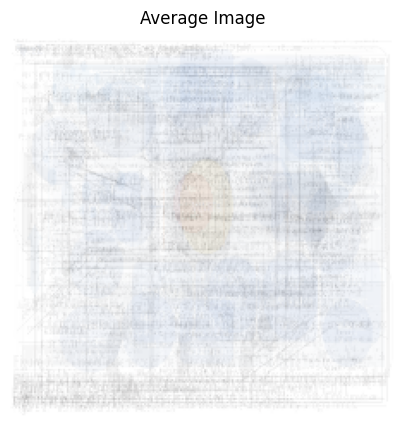

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input


def load_and_preprocess_images(directory, target_size=(224, 224)):
    image_paths = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith(('.png', '.jpg', '.jpeg'))]
    images = [load_img(path, target_size=target_size) for path in image_paths]
    images_array = np.array([img_to_array(image) for image in images])
    images_array = preprocess_input(images_array)
    return images, images_array, image_paths

def average_images(images):
    images_array = np.array([img_to_array(image) for image in images])
    average_image = np.mean(images_array, axis=0)
    return average_image

# Load images from a specific directory
directory = "../clustered_images/2022/conceptual diagram/cluster_0"
images, images_array, image_paths = load_and_preprocess_images(directory)

# Compute the average image
average_image = average_images(images)

# Display the average image
plt.figure(figsize=(5, 5))
plt.imshow(average_image.astype(np.uint8))  # Convert float to uint8 for display
plt.title('Average Image')
plt.axis('off')
plt.show()


## Necessary Funcitons and Variables

## No Photos / Drawing Average

## Diagram Type Average

## Process & Conceptual Subcategory Average

## Process Diagram Average

## Conceptual Diagram Average

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.cluster import KMeans
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

def load_and_preprocess_images(directory, target_size=(224, 224)):
    image_paths = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith(('.png', '.jpg', '.jpeg'))]
    images = [load_img(path, target_size=target_size) for path in image_paths]
    images_array = np.array([img_to_array(image) for image in images])
    images_array = preprocess_input(images_array)
    return images, images_array

def extract_features(images_array):
    model = VGG16(weights='imagenet', include_top=False)
    features = model.predict(images_array)
    features_flattened = features.reshape(features.shape[0], -1)
    return features_flattened

def cluster_features(features_flattened, n_clusters=1):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(features_flattened)
    return kmeans.cluster_centers_


def visualize_feature_maps(cluster_center, model):
    # Assume a typical output shape for VGG16 with 224x224 input
    assumed_shape = (7, 7, 512)
    try:
        # Reshape the cluster_center to (7, 7, 512)
        feature_maps = cluster_center.reshape(assumed_shape)
        plt.figure(figsize=(15, 10))
        num_maps = min(49, feature_maps.shape[-1])  # Show up to 49 feature maps
        for i in range(num_maps):
            plt.subplot(7, 7, i + 1)
            plt.imshow(feature_maps[:, :, i], cmap='viridis')
            plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"An error occurred: {e}")




def initialize_model():
    # Define the input tensor with a specific size
    input_tensor = Input(shape=(224, 224, 3))
    # Load the VGG16 model with weights and without the fully connected layers
    model = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)
    return model



# Load images from a specific directory
directory = "../clustered_images/2022/conceptual diagram/cluster_0"
images, images_array = load_and_preprocess_images(directory)

# Extract features
features_flattened = extract_features(images_array)

# Cluster features into 1 cluster
cluster_centers = cluster_features(features_flattened, n_clusters=1)
print(cluster_centers[0])

# Load the VGG16 model for reverse engineering
vgg_model = initialize_model()
print('hi')


# Visualize the hypothetical image from the cluster center
visualize_feature_maps(cluster_centers[0], vgg_model)
